<table>
<tr><td><img style="height: 150px;" src="images/geo_hydro1.jpg"></td>
<td bgcolor="#FFFFFF">
    <p style="font-size: xx-large; font-weight: 900; line-height: 100%">AG Dynamics of the Earth</p>
    <p style="font-size: large; color: rgba(0,0,0,0.5);">Jupyter notebooks</p>
    <p style="font-size: large; color: rgba(0,0,0,0.5);">Georg Kaufmann</p>
    </td>
</tr>
</table>

# Dynamic systems: 6. Viscous material
## Hagen-Poiseuille flow with `simpleFoam`
----
*Georg Kaufmann,
Geophysics Section,
Institute of Geological Sciences,
Freie Universität Berlin,
Germany*

**In this notebook, we will learn to**

- establish a typical **Hagen-Poiseuille flow** profile in a rectangular channel
in `openFoam`, using `simpleFoam`. 

**Prerequisites:** (text)

**Result:** You should get a figure similar to
<img src="images/HagenPoiseuille_run2D.jpg" style=width:10cm>

<a href="#top">**Table of contents**</a>

1. [Solver and equations](#one)
2. [Implementation](#two)
3. [Running](#three)
4. [Post-processing](#four)
5. [Technical aspects](#five)

<div id="one"></div>

----
## 1. Solver and equations

`simpleFoam` is a 

- steady-state
- incompressible
- laminar/turbulent

solver for the continuity and momentum equations:
$$
\begin{array}{rcl}
\nabla \cdot \vec{u} &=& 0 \\
\rho \left( \vec{u} \cdot \nabla \right) \vec{u}
&=& - \nabla p
+ \eta \Delta \vec{u}
\end{array}
$$
with
$\rho$ [kg/m$^3$] density,
$\vec{u}$ [m/s] velocity,
$p$ [Pa] pressure,
$\eta$ [Pas] dynamic viscosity.

Note that `simpleFoam` as incompressible solver solves for the kinematic pressure, ${{p}\over{\rho}}$, thus
the Navier-Stokes equation is reformulated:
$$
\left( \vec{u} \cdot \nabla \right) \vec{u}
- \nu \Delta \vec{u}
= - \nabla \frac{p}{\rho}
$$
with
$\nu={{\eta}\over{\rho}}$ [m$^2$/s] kinematic viscosity.

The equations are then solved by `simpleFoam`.

<div id="two"></div>

----
## 2.  Implementation

We consider flow along a channel 10 m long, 1 m in cross section:
<img src="images/HagenPoiseuille.jpg" style=width:15cm>
Black numbers mark sizes, red numbers are vertex numbers.

For the calculation of velocities and pressure, we have an inflow face (0 4 7 3) with fixed velocity
in $y$ direction, and an outflow face (1 2 6 2) with fixed (kinematic) pressure.
The numbering of faces mark the **unit normal vector** in a right-hand side sense, thus for both
faces, the unit vector points outwards.

The other faces (left,right,top,bottom) will be defined as **no-slip** boundaries, 
thus they will be defined with velocity zero.

We have to set up the **mesh**, the **initial conditions**, a **temperature anomaly**, then **run** the program.
This is done for the 2D case in the following.

### Directory structure and files

~~~
HagenPoiseuille_simpleFoam
|-- 0
  |-- U
  |-- p
|- constant
  |-- turbulenceProperties
  |-- transportProperties
|- system
  |-- blockMesh
  |-- controlDict
  |-- fvSchemes
  |-- fvSolution
~~~

The dictionaries `blockMesh`, `0/U`, and `0/p`remain unchanged...

----

- `system/blockMeshDict`
    - We use no scaling (`convertToMeters`)
    - Eight vertices are defined (`vertices`), use the figure above. The model domain is 10m long in $y$ direction, 
    and has dimensions of $\pm$0.5m in $x$ and $z$ direction.
    - From the eight vertices, a single block (`blocks`) is created as mesh,
    discretised with 100 points in $y$ direcion, ans 10 points in $x$ and $z$ directions.
    Choose direction of points such that the normal vectors are pointing outside! Create one block, withh 1000 elements in $x$ direction.
    - All edges are straight, thus the keyword `edges` is empty.
    - The boundries are defined (`boundary`). Only two faces, inflow and outflow side, are relevant, 
    and defined as patches. The other four faces (left,right,top,bottom), are no-slip boundaries.



<details><summary><b>> Show code</b></summary>

~~~
convertToMeters 1;

vertices
(
    (-0.5   0.0  -0.5)
    ( 0.5   0.0  -0.5)
    ( 0.5  10.0  -0.5)
    (-0.5  10.0  -0.5)
    (-0.5   0.0   0.5)
    ( 0.5   0.0   0.5)
    ( 0.5  10.0   0.5)
    (-0.5  10.0   0.5)
);

blocks
(
    hex (0 1 2 3 4 5 6 7) ( 10 100 10) simpleGrading (1 1 1)
);

edges
(
);

boundary
(
    inlet
    {
        type patch;
        faces
        (
            (0 1 5 4)
        );
    }
    outlet
    {
        type patch;
        faces
        (
            (2 3 7 6)
        );
    }
    left
    {
        type wall;
        faces
        (
            (0 4 7 3)
        );
    }
    right
    {
        type wall;
        faces
        (
            (1 2 6 5)
        );
    }
    bottom
    {
        type wall;
        faces
        (
            (0 3 2 1)
        );
    }
    top
    {
        type wall;
        faces
        (
            (4 5 6 7)
        );
    }
);

mergePatchPairs
(
);
~~~
</details>

----

- `0/U`
    - Dimensions are set for velocities (`dimensions`).
    - Set all velocities to zero, except the inlet face.
    - At the `inlet`, set velocity to 1 m/s in $y$ direction.
    - At the `outlet`, set velocity to zero gradient.
    - Fix velocities along other edges to a fixed value and to zero.

<details><summary><b>> Show code</b></summary>

~~~
dimensions      [0 1 -1 0 0 0 0];
internalField   uniform (0 0 0);
boundaryField
{
    inlet
    { type            fixedValue;
      value           uniform (0 1 0);
    }

    outlet
    { type      zeroGradient;
    }

    left
    { type            fixedValue;
      value           uniform (0 0 0);
    }

    right
    { type            fixedValue;
      value           uniform (0 0 0);
    }

    bottom
    { type            fixedValue;
      value           uniform (0 0 0);
    }

    top
    { type            fixedValue;
      value           uniform (0 0 0);
    }   
}
~~~
</details>

----

- `0/p`
    - Dimensions are set for pressure (`dimensions`).
    - Set all pressures to zero gradient, 
    - except the outlet face, where a fixed value is used
    and set to 0 m/s.
    - Note that for `icoFoam`, which is an incompressible solver, the pressure is scaled by density:
    $$
    p^* = \frac{p}{\rho}
    $$
    with $p$ [Pa] pressure and $\rho$ [kg/m$^3$] density, thus $p^*$ [m$^2$/s$^2$].

<details><summary><b>> Show code</b></summary>

~~~
dimensions      [0 2 -2 0 0 0 0];

internalField   uniform 0;

boundaryField
{
    inlet
    { type            zeroGradient;
    }

    outlet
    { type            fixedValue;
      value           $internalField;
      //type        zeroGradient;
    }

    left
    { type      zeroGradient;           
    }

    right
    { type      zeroGradient;           
    }

    bottom
    { type      zeroGradient;
    }

    top
    { type      zeroGradient;
    }
}
~~~
</details>


----

- `constant/turbulenceProperties`
    - set simulation type, in this case to **laminar** (`simulationType`). 

<details><summary><b>> Show code</b></summary>

~~~
simulationType laminar;
~~~
</details>

----

- `constant/transportProperties`
    - define **kinematic viscosity** $\nu=\frac{\eta}{\rho}$ [m$^2$/s] from
    - **dynamic viscosity** $\eta$ [Pa] and
    - **density** $\rho$ [kg/m$^3$]
    - The value is choosen to remain in the **laminar** flow regime, which is
    defined via the **Reynolds number** as
    $$
    Re = \frac{\rho u L}{\eta} = \frac{u L}{\nu}
    $$
    For $Re=100$, $u=1$m/s, and $L\simeq 1$m, we therefore need $\nu=0.01$m$^2$/s
    (which is way to large for water!). 
    - **NEW:** As `simpleFoam`can handle non-Newtonian fluids, we need to set the model to Newtonian
    (`transportModel`).

<details><summary><b>> Show code</b></summary>

~~~
transportModel  Newtonian;
nu              nu [ 0 2 -1 0 0 0 0 ] 0.01;
~~~
</details>

----

- `system/controlDict`

    - We use a **steady-state** solver, thus the time stepping is not used in the original sense,
    but only `endTime` as a maximum iteration counter

<details><summary><b>> Show code</b></summary>

~~~
application     simpleFoam;
startFrom       startTime;
startTime       0;
stopAt          endTime;
endTime         1000;
deltaT          1;
writeControl    runTime;
writeInterval   10;
purgeWrite      0;
writeFormat     ascii;
writePrecision  8;
writeCompression off;
timeFormat      general;
timePrecision   6;
runTimeModifiable true;
~~~
</details>

----

- `system/fvSchemes`

    - Time scheme is **steady state** (`ddtSchemes`).
    - Gradients are solved with the Gauss linear methods (`gradSchemes`).
    - Divergence is solved with a bounded linear interpolation method (`divSchemes`).
    - The new term `div((nuEff*dev2(T(grad(U)))))`is needed, because the solver `simpleFoam`
    can handle turbulence (which we do not need).
    - Laplacians are solved with a Gauss linear method (`laplacianSchemes`).

<details><summary><b>> Show code</b></summary>

~~~
ddtSchemes
{
    default         steadyState;
}

gradSchemes
{
    default         Gauss linear;
    grad(p)         Gauss linear;
}

divSchemes
{
    default         none;
    div(phi,U)      bounded Gauss linear;
    div((nuEff*dev2(T(grad(U)))))     Gauss linear;
}

laplacianSchemes
{
    default         Gauss linear orthogonal;
}

interpolationSchemes
{
    default         linear;
}

snGradSchemes
{
    default         orthogonal;
}
~~~
</details>

----

- `system/fvSolution`

    - Pressure $p$ is solved with the **GAMG** method to a given absolute tolerance,
    and a given relative tolerance.
    - Velocities $U$ are solved with the **PBiCG** method and **DILU** preconditioning,
    and tolerances are set.
    - The **SIMPLE** block defines the pressure-velocity coupling with the **simple** method.
    - The `relaxationFactors` are needed for the under-relaxation scheme, and the solution
    is fairly sensitive to them. A good starting point for the different variables is:
    |variable|value|
    |--------|-----|
    |p       |0.3; |
    |U       |0.7; |
    |k       |0.7; |
    |omega   |0.7; |
    |epsilon |0.7; |

<details><summary><b>> Show code</b></summary>

~~~
solvers
{
    p
    {
        solver           GAMG;
        tolerance        1e-6;
        relTol           0.01;
        smoother         GaussSeidel;
        nPreSweeps       0;
        nPostSweeps      2;
        cacheAgglomeration on;
        agglomerator     faceAreaPair;
        nCellsInCoarsestLevel 100;
        mergeLevels      1;
    }

    U
    {
        solver          PBiCG;
        preconditioner  DILU;
        tolerance       1e-08;
        relTol          0;
    }
}

SIMPLE
{
    nNonOrthogonalCorrectors 1;
    residualControl
    {
        p 1e-4;
        U 1e-4;
    }
}

relaxationFactors
{
    fields
    {
        p 0.3;
    }
    equations
    {
        U 0.7;
    }
}
~~~
</details>


### Reynolds number

We want to make sure that flow remains laminar. We use the **Reynolds number**:
$$
Re = {{\rho u L}\over{\eta}} = {{u L}\over{\nu}} 
$$
with $\eta$ [Pas] the dynamic viscosity,
$\rho$ [kg/m$^3$] density,
$\nu={{\eta}\over{\rho}}$ [m$^2$/s] kinematic viscosity,
$u$ [m/s] velocity, and
$L$ [m] a length scale.

For $Re < 2000$, flow remains laminar. With $u=1$ m/s, $Re = 100$, $L=1$ m, we find a kinematic viscosity of
$\nu=0.01$ m$^2$/s (which of course does not represent water).

<div id="three"></div>

----
## 3. Running

Running a particular example is done with the following set of commands:

~~~
$ foamCleanTutorials
$ blockMesh
$ simpleFoam
~~~

If the run was successful, create a dummy file `show.foam` in the directory and
open the run in `paraview`.

<img src="images/HagenPoiseuille_run2D.jpg" style=width:20cm>

<div id="four"></div>

----
## 4. Post-processing: Profiles

Use dictionary `system/sampleDict` to extract data after main run.
- We define `sets`
- We set the output format to ascii (`setFormat raw`).
- We set the interpolation as cell-point centeres (*interpolationScheme`).
- The fields are defined (`fields`). Note that is matters, wether the different fields
are in one line or in separate line, as this controls the naming of the output files ...
- Then the sets are given, with a name (e.g. `HagenPoiseuille_simple_along`), the sample type
(`type uniform`) and the sample number (`nPoints 100`), the axes to sample (`xyz`means
all three axes), and the start and end points of the uniform sampling (`start`, `end`).

<details><summary><b>> Show code</b></summary>
    
~~~
type sets;

setFormat raw;

//interpolationScheme cell;
interpolationScheme cellPoint;
//interpolationScheme cellPointFace;

// Fields to sample.
fields
(
    U
    p
);

sets
(
    HagenPoiseuille_simple_along
    {
        type          uniform;
        nPoints       100;

        axis            xyz;
        start           ( 0   0 0);
        end             ( 0  10 0);
    }
    HagenPoiseuille_simple_perpendicular
    {
        type            uniform;
        nPoints         100;

        axis            xyz;
        start           (-0.5 10 0);
        end             ( 0.5 10 0);
    }

);
~~~
</details>

Run:

~~~
$ postProcess -func sampleDict -latestTime
~~~

The `postProcess` code creates in this case sampled data for velocity $U$ and the reduced pressure $p^*$
for two cases:
- along the channel:  
    - `postProcessing/sampleDict/20/HagenPoiseuille_simple_along_U.xy`
    - `postProcessing/sampleDict/20/HagenPoiseuille_simple_along_p.xy`
- perpendicular to channel:  
    - `postProcessing/sampleDict/20/HagenPoiseuille_simple_perpendicular_U.xy`
    - `postProcessing/sampleDict/20/HagenPoiseuille_simple_perpendicular_p.xy`

[<AxesSubplot:> <AxesSubplot:>]


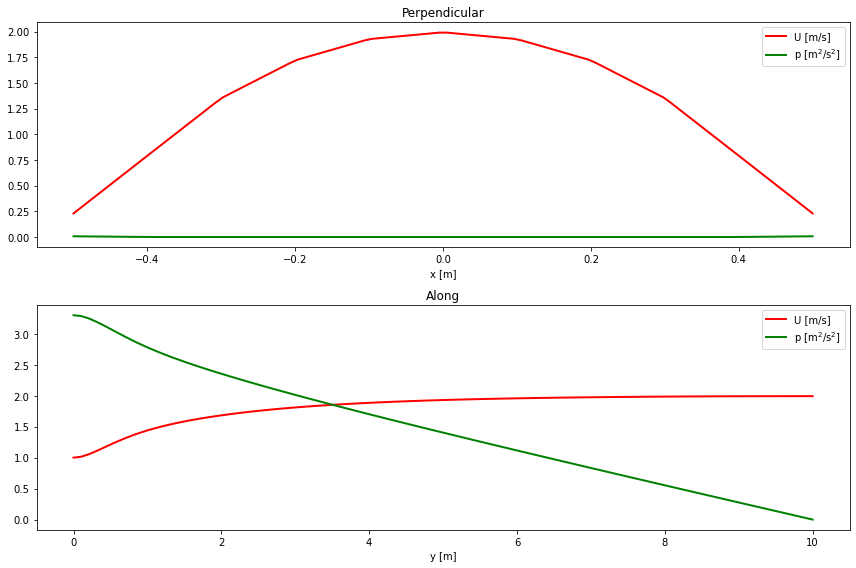

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# calculate analytical data
def T(x,T0=400,T1=500):
    Hsternrhocp = 1e-5
    D           = 1e-6
    L           = 10
    c1 = (T1-T0)/L + Hsternrhocp/2/D*L
    c2 = T0
    T = -Hsternrhocp/2/D*x**2 + c1*x + c2
    return T
    
# load laplacianFoam postprocessed data
data1U = np.loadtxt('data/HagenPoiseuille_simple_perpendicular_U.xy')
data1p = np.loadtxt('data/HagenPoiseuille_simple_perpendicular_p.xy')
data2U = np.loadtxt('data/HagenPoiseuille_simple_along_U.xy')
data2p = np.loadtxt('data/HagenPoiseuille_simple_along_p.xy')

fig, axs = plt.subplots(2, 1,figsize=(12,8))
print(axs)
axs[0].set_xlabel('x [m]')
axs[0].set_title('Perpendicular')
axs[0].plot(data1U[:,0],data1U[:,4],linewidth=2,color='red',label='U [m/s]')
axs[0].plot(data1p[:,0],data1p[:,3],linewidth=2,color='green',label='p [m$^2$/s$^2$]')
axs[0].legend()

axs[1].set_xlabel('y [m]')
axs[1].set_title('Along')
axs[1].plot(data2U[:,1],data2U[:,4],linewidth=2,color='red',label='U [m/s]')
axs[1].plot(data2p[:,1],data2p[:,3],linewidth=2,color='green',label='p [m$^2$/s$^2$]')
axs[1].legend()
plt.tight_layout()

----
## 5. Add transport ...

Next, we create a **new** module in the `openFoam` package, which we call
`icoScalarTransportFoam`...

... done